In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Домашнее задание

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:
    - https://www.kaggle.com/carlolepelaars/camvid
    
2. Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image

Опишем пути для доступа к данным (делал в ноутбуке на kaggle)

In [ ]:
class_dict = pd.read_csv('../input/camvid/CamVid/class_dict.csv')

path_train = '../input/camvid/CamVid/train/'
path_train_labels = '../input/camvid/CamVid/train_labels/'
path_test = '../input/camvid/CamVid/test/'
path_test_labels = '../input/camvid/CamVid/test_labels/'
path_val = '../input/camvid/CamVid/val/'
path_val_labels = '../input/camvid/CamVid/val_labels/'

In [ ]:
train_images_paths = list(Path(path_train).iterdir())

In [ ]:
single_image = image.load_img(train_images_paths[0])
image_size = (int(single_image.size[0]/2), single_image.size[1])
image_size

(480, 720)

## Загрузим картинки

In [ ]:
from keras.preprocessing import image

train_imgs_paths = list(sorted(Path(path_train).iterdir()))
train_masks_paths = list(sorted(Path(path_train_labels).iterdir()))
test_imgs_paths = list(sorted(Path(path_test).iterdir()))
test_masks_paths = list(sorted(Path(path_test_labels).iterdir()))
val_imgs_paths = list(sorted(Path(path_val).iterdir()))
val_masks_paths = list(sorted(Path(path_val_labels).iterdir()))

Определим размер картинки

In [ ]:
image_size = (128, 192)

Создадим списки с исходными картинками и масками из трейна

In [ ]:
train_images = []
train_masks = []

for i_img, i_mask in zip(train_imgs_paths, train_masks_paths):
    train_images.append(image.load_img(i_img, target_size=image_size))
    train_masks.append(image.load_img(i_mask, target_size=image_size))

Визуализируем одну из картинок и ее маску

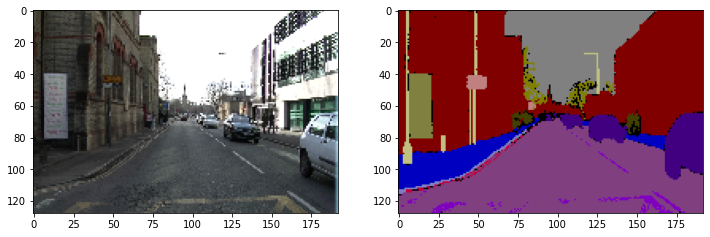

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(train_images[120].convert('RGBA'))
ax[1].imshow(train_masks[120].convert('RGBA'))

In [ ]:
train_images[120].size

(192, 128)

Сделаем то же самое для тестовых и валидационных картинок

In [ ]:
test_images = []
test_masks = []

for i_img, i_mask in zip(test_imgs_paths, test_masks_paths):
    test_images.append(image.load_img(i_img, target_size=image_size))
    test_masks.append(image.load_img(i_mask, target_size=image_size))

In [ ]:
val_images = []
val_masks = []

for i_img, i_mask in zip(val_imgs_paths, val_masks_paths):
    val_images.append(image.load_img(i_img, target_size=image_size))
    val_masks.append(image.load_img(i_mask, target_size=image_size))

Создадим обучающий датасет, переведем представление картинок в массивы

In [ ]:
X_train = []

for img in train_images:
  x = image.img_to_array(img)
  X_train.append(x)

X_train = np.array(X_train)

Создадим тестовый датасет, переведем представление картинок в массивы

In [ ]:
X_test = []

for img in test_images:
  x = image.img_to_array(img)
  X_test.append(x)

X_test = np.array(X_test)

Создадим валидационный датасет, переведем представление картинок в массивы

In [ ]:
X_val = []

for img in val_images:
  x = image.img_to_array(img)
  X_val.append(x)

X_val = np.array(X_val)

Посмотрим на классы, которые есть на картинках

In [ ]:
class_dict

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


Создадим список со значениями каналов rgb для каждого класса

In [ ]:
arr_col = []

for r, g, b in zip(class_dict['r'], class_dict['g'], class_dict['b']):
  arr_col.append([r, g, b]) 

Сделаем функцию, которые возвращает массив с разметкой по классам, а также отдельные фильтры (каналы), где выделены пиксели конкретного класса

In [ ]:
import cv2


def Color2index(y, arr_col=arr_col):

    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where(
            (y[..., 0] == i_color[0]) 
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind#, i-1

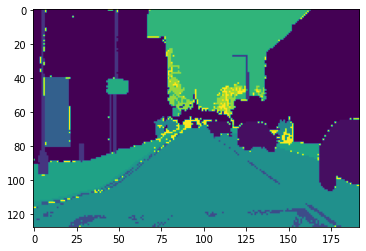

In [ ]:
cat_yi, ind_yi = Color2index(image.img_to_array(train_masks[120]))
plt.imshow(ind_yi)
plt.show() 

Выведем маски зданий

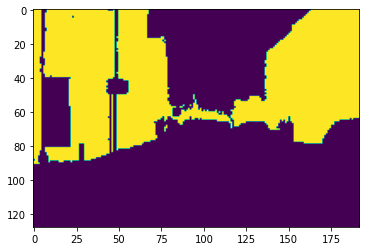

In [ ]:
plt.imshow(cat_yi[..., 4])
plt.show()

Выведем маски автомобилей

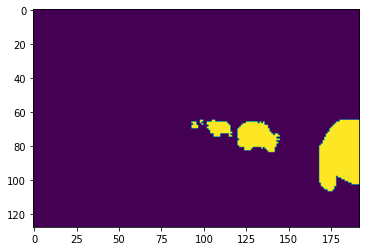

In [ ]:
plt.imshow(cat_yi[..., 5])
plt.show()

Сделаем массив масок для обучающего, тестового и валидационного датасетов

In [ ]:
y_train = []

for mask in train_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_train.append(y_cat)

y_train = np.array(y_train)

In [ ]:
y_test = []

for mask in test_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_test.append(y_cat)

y_test = np.array(y_test)

In [ ]:
y_val = []

for mask in val_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_val.append(y_cat)

y_val = np.array(y_val)

Посмотрим на размерности обучающего датасета

In [ ]:
print(X_train.shape)
print(y_train.shape)

(369, 128, 192, 3)
(369, 128, 192, 32)


Построим архитектуру Unet на предобученной VGG16

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model


def unet_pre_train(num_classes=32, input_shape=(128, 192, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, 
                                 weights='../input/keraspretrainedmodel/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

    for layer in pre_trained_model.layers[:-5]:
        layer.trainable = False

    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
   
    # UP 1

    # добавили перенос из VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

2022-03-20 10:42:00.065646: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


KerasTensor(type_spec=TensorSpec(shape=(None, 16, 24, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 48, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 96, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")


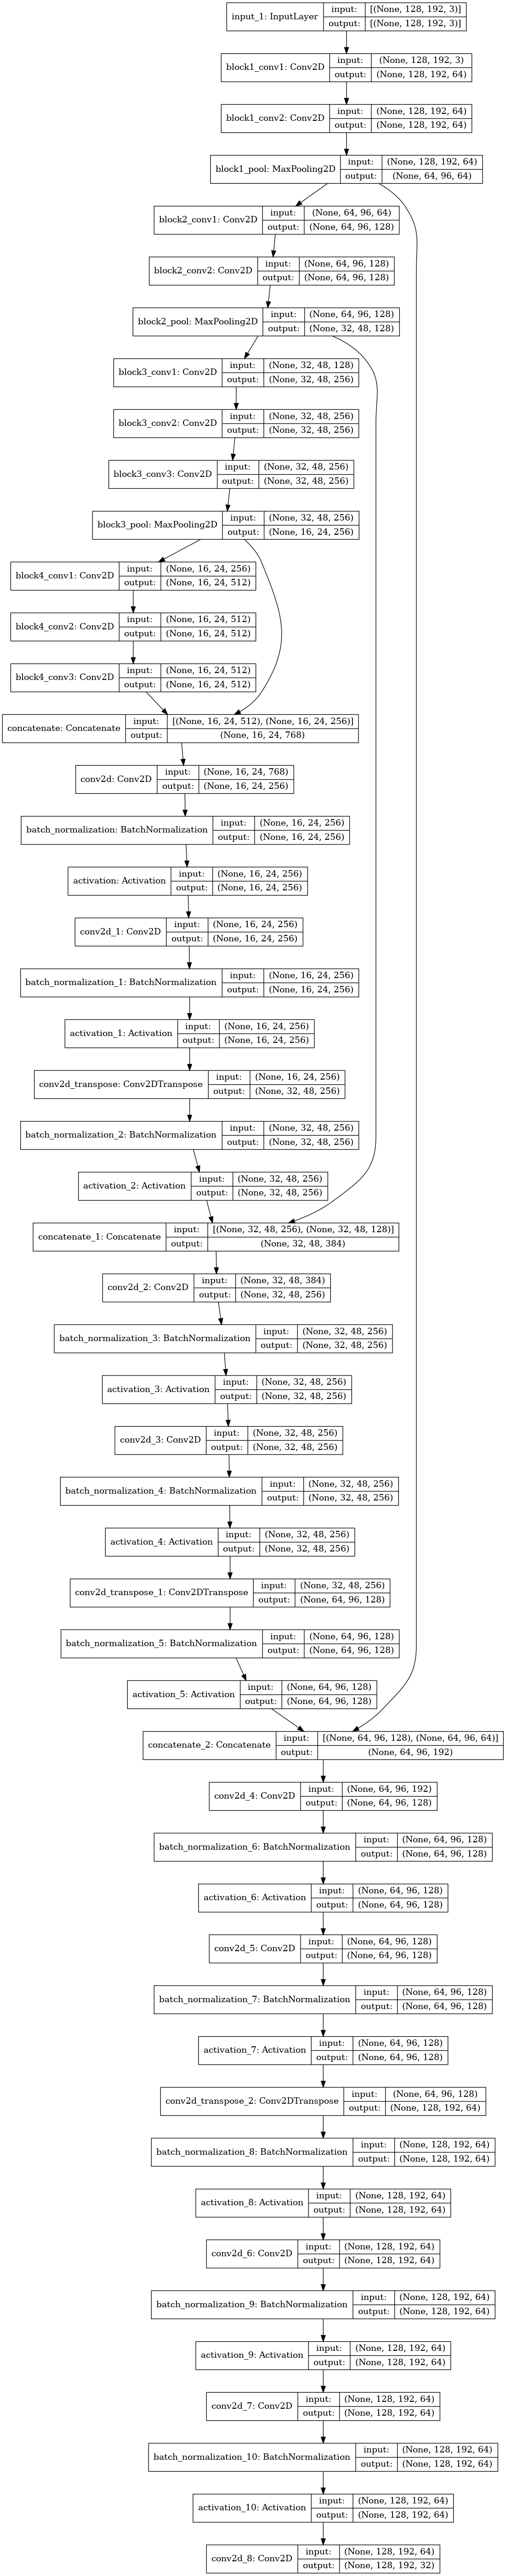

In [ ]:
model = unet_pre_train(32, (128, 192, 3))

plot_model(model, to_file='model.png', show_shapes=True)

Создадим функцию подсчета DICE

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

Скомпилируем сеть

In [ ]:
from tensorflow.keras.optimizers import Adam


model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 192, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 192, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 96, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
sample_image = X_test[1]
sample_mask = y_test[1]

- Ниже функция для визуализации исходной картинки, маски и результата предсказания сети

- И кастомный коллбэк, который визуализирует результат промежуточные предсказания модели в процессе обучения на через заданный интервал эпох


In [ ]:
import keras
from IPython.display import clear_output


def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 16]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 16])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()

class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

2022-03-20 10:42:04.702410: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(1, 128, 192)


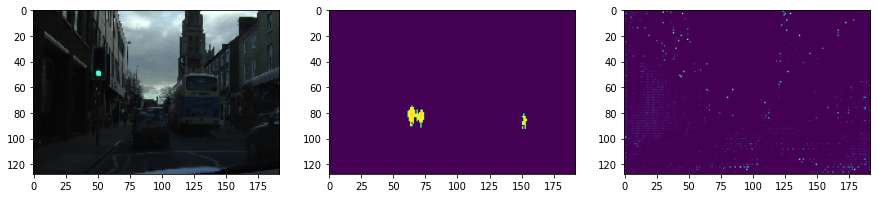

In [ ]:
show_predictions(model)

(1, 128, 192)


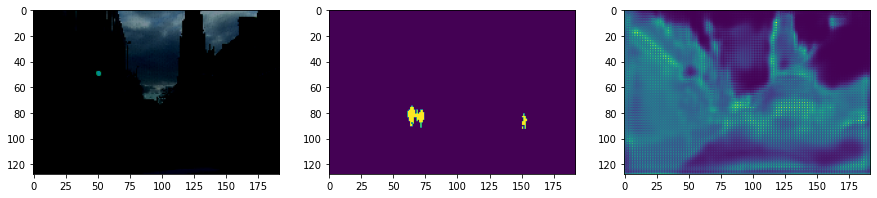


Sample Prediction after epoch 10


In [ ]:
history = model.fit(preprocess_input(X_train), y_train,
                      epochs=10,
                      batch_size=20,
                      validation_data=(preprocess_input(X_test), y_test),
                      callbacks=[DisplayCallback(patience=5)])

Визуализируем качество предсказания на трейне и тесте

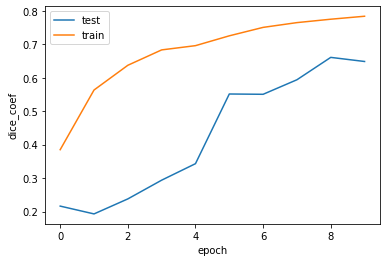

In [ ]:
plt.plot(history.history['val_dice_coef'], label='test')
plt.plot(history.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

Тестируем на валидационных данных

In [ ]:
pred = model.predict(X_val)
print(pred.shape)

(100, 128, 192, 32)


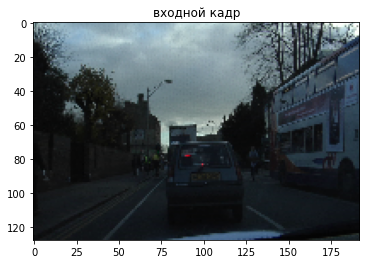

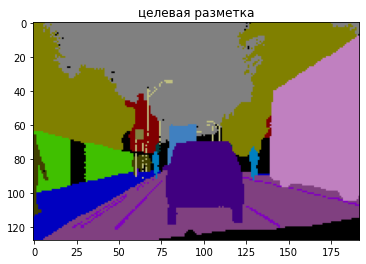

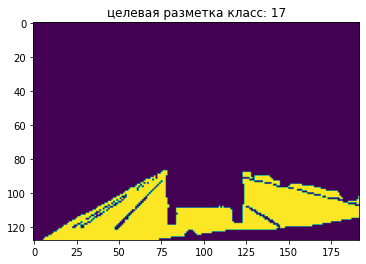

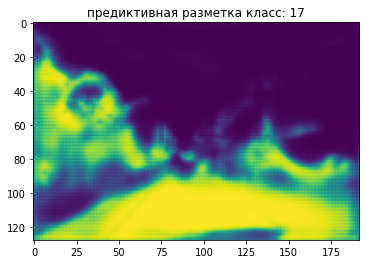

In [ ]:
n = 1
class_ = 17
plt.imshow(val_images[n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(val_masks[n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = y_val[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()

Измерим метрику MeanIoU

In [ ]:
from keras.metrics import MeanIoU

m = MeanIoU(num_classes=32)
m.update_state(y_val, pred)
m.result().numpy()

0.43611583

# Выводы:

метрика на валидации достаточно низкая.

Основные причины:
- мало эпох
- неоптимальная архитетура сети (к сожалению, времени на эксперименты нет)
- много классов и мало примеров

Юля, в целом я воспользовался вашим кодом на кэгле для выполнения этого задания, но я все попринтил и разобрался, что и для чего делается 